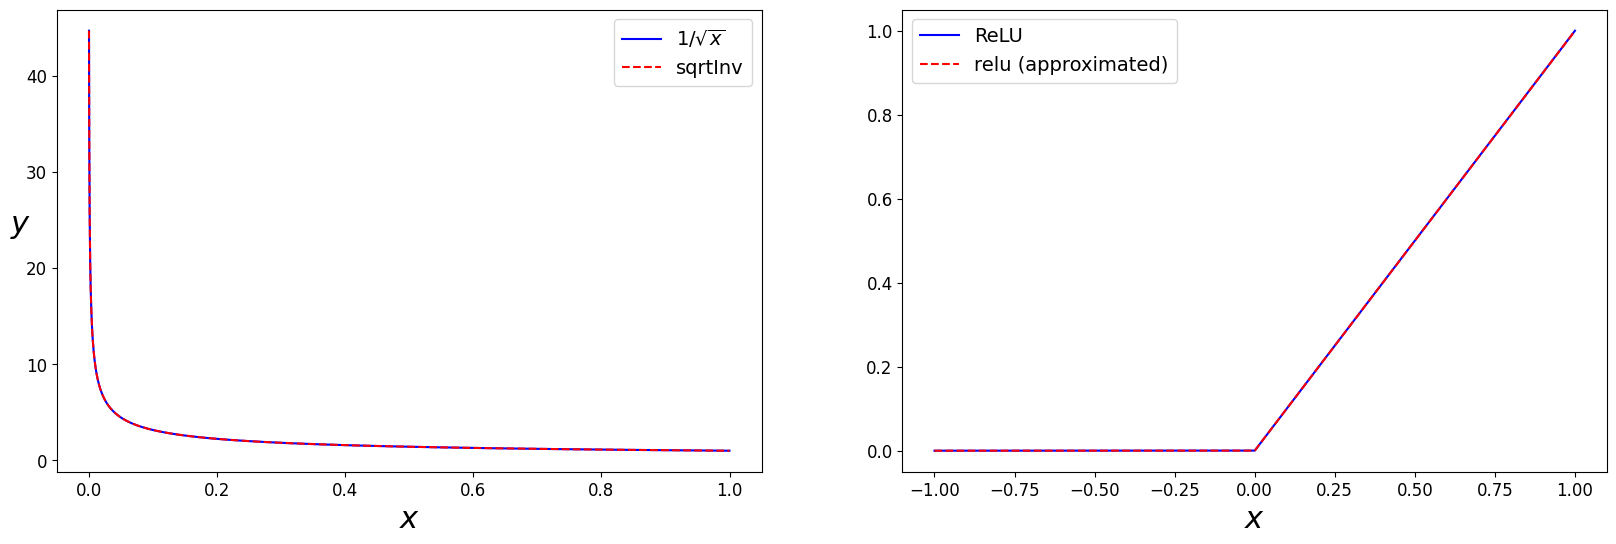

In [7]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt

def chebishev(a, b, x, d): 
    y = (2*x-(a+b))/(b-a)
    l = [1, y] # order 0
    for i in range(d-1):
        l.append(2*y*l[len(l)-1]-l[len(l)-2])
    return l                 

def evalcheb(coeffs, x, a, b):
    d = len(coeffs) - 1
    l = chebishev(a, b, x, d)
    return sum(coeffs[i]*l[i] for i in range(len(coeffs)))

def polyeval(coeffs, x):
    return sum(coeffs[i]*(math.pow(x, i)) for i in range(len(coeffs)))

def polyeval_torch(coeffs, x):
    return sum(coeffs[i]*(x**i) for i in range(len(coeffs)))

# ReLU 근사 함수 정의
def ReLU_torch_64(x):
    f1_coeffs = torch.tensor([1.34595769293910e-33, 2.45589415425004e1, 4.85095667238242e-32, -6.69660449716894e2,
                              -2.44541235853840e-30, 6.67299848301339e3, 1.86874811944640e-29, -3.06036656163898e4,
                              -5.76227817577242e-29, 7.31884032987787e4, 8.53680673009259e-29, -9.44433217050084e4,
                              -6.02701474694667e-29, 6.23254094212546e4, 1.62342843661940e-29, -1.64946744117805e4], dtype=torch.float64)
    
    f2_coeffs = torch.tensor([1.53261588585630e-47, 9.35625636035439, -3.68972123048249e-46, -5.91638963933626e1,
                              1.74254399703303e-45, 1.48860930626448e2, -3.20672110002213e-45, -1.75812874878582e2,
                              2.79115738948645e-45, 1.09111299685955e2, -1.22590309306100e-45, -3.66768839978755e1,
                              2.62189142557962e-46, 6.31846290311294, -2.16662326421275e-47, -4.37113415082177e-01], dtype=torch.float64)
    
    g_coeffs = torch.tensor([6.43551938319983e-48, 5.07813569758861, 8.12601038855762e-46, -3.07329918137186e1,
                             -1.60198474678427e-44, 1.44109746812809e2, 1.07463154460511e-43, -4.59661688826142e2,
                             -3.63448723044512e-43, 1.02152064470459e3, 7.25207125369784e-43, -1.62056256708877e3,
                             -9.27306397853655e-43, 1.86467646416570e3, 7.95843097354065e-43, -1.56749300877143e3,
                             -4.69190103147527e-43, 9.60970309093422e2, 1.90863349654016e-43, -4.24326161871646e2,
                             -5.27439678020696e-44, 1.31278509256003e2, 9.47044937974786e-45, -2.69812576626115e1,
                             -9.98181561763750e-46, 3.30651387315565, 4.69390466192199e-47, -1.82742944627533e-1], dtype=torch.float64)
    
    return 0.5*( x + x*(polyeval_torch(g_coeffs, polyeval_torch(f2_coeffs, polyeval_torch(f1_coeffs, x)))))

class Approx_ReLU(nn.Module):
    def __init__(self):
        super(Approx_ReLU, self).__init__()

    def forward(self, x):
        # Apply ReLU function: max(0, x)
        x = x.to(dtype=torch.float64)
        return (ReLU_torch_64(x / 1) * 1).half()

# 1/sqrt(x) 근사 함수 정의
def Inverse_sqrt_approx(x):
    coeffs = torch.tensor([ 3.9359587065628147684037685394287109375, -5.3255082193645648658275604248046875, 
                            4.4768915243548690341413021087646484375, -3.96794509016399388201534748077392578125, 
                            3.60465136755010462366044521331787109375, -3.322337739053182303905487060546875, 
                            3.0916074502383708022534847259521484375, -2.896631363124470226466655731201171875, 
                            2.72791187408074620179831981658935546875, -2.5793033506706706248223781585693359375, 
                            2.44660075974752544425427913665771484375, -2.32680037745376466773450374603271484375, 
                            2.217681929774698801338672637939453125, -2.117557876961654983460903167724609375, 
                            2.02511555564342415891587734222412109375, -1.939313754808608791790902614593505859375, 
                            1.859312654458335600793361663818359375, -1.784424995074004982598125934600830078125, 
                            1.714081198746498557738959789276123046875, -1.64780391713065910153090953826904296875, 
                            1.58518910566999693401157855987548828125, -1.525891713941746274940669536590576171875, 
                            1.46961470393944182433187961578369140625, -1.416100508829913451336324214935302734375,
                            1.365124309084421838633716106414794921875, -1.316488680937254684977233409881591796875, 
                            1.27001929425387061201035976409912109375, -1.225561422210375894792377948760986328125, 
                            1.18297708568934467621147632598876953125, -1.142142698741736239753663539886474609375, 
                            1.1029471132133039645850658416748046875, -1.065289984026094316504895687103271484375, 
                            1.0290803940370096825063228607177734375, -0.994235690528512350283563137054443359375, 
                            0.9606804954719336819835007190704345703125, -0.928345859307228238321840763092041015625, 
                            0.897168534005686524324119091033935546875, -0.867090345798715134151279926300048828125, 
                            0.838057651637427625246345996856689453125, -0.81002086631997372023761272430419921875, 
                            0.7829340495736687444150447845458984375, -0.756754544194336631335318088531494140625, 
                            0.7314426578695929492823779582977294921875, -0.7069613825196938705630600452423095703125, 
                            0.6832761459818357252515852451324462890625, -0.66035459167324006557464599609375, 
                            0.6381663825550276669673621654510498046875, -0.61668302624821080826222896575927734375, 
                            0.59587771864244132302701473236083984375, -0.5757252037028592894785106182098388671875, 
                            0.5562016475150812766514718532562255859375, -0.5372845248775774962268769741058349609375, 
                            0.5189525169762418954633176326751708984375, -0.501185418879686039872467517852783203125, 
                            0.48396405575249445973895490169525146484375, -0.46727020682146758190356194972991943359375, 
                            0.45108653626766681554727256298065185546875, -0.43539653029665714711882174015045166015625, 
                            0.42018443975166519521735608577728271484375, -0.4054352276943973265588283538818359375, 
                            0.39113452145875271526165306568145751953125, -0.37726856872495773131959140300750732421875, 
                            0.36382419723258863086812198162078857421875, -0.35078877777186789899133145809173583984375, 
                            0.33815019015173675143159925937652587890625, -0.32589679186048670089803636074066162109375, 
                            0.31401738917838883935473859310150146484375, -0.30250121051676615024916827678680419921875, 
                            0.291337881781146279536187648773193359375, -0.28051740359296672977507114410400390625, 
                            0.270030130193845252506434917449951171875, -0.25986674990053870715200901031494140625, 
                            0.2500182669709829497151076793670654296875, -0.24047598477091014501638710498809814453125, 
                            0.231231490130767269874922931194305419921875, -0.22227663879448300576768815517425537109375, 
                            0.213603541877319003106094896793365478515625, -0.205204553248449883540160953998565673828125, 
                            0.19707225776937775663100183010101318359375, -0.18919946031883227988146245479583740234375, 
                            0.181579175545493853860534727573394775390625, -0.17420461829487976501695811748504638671875, 
                            0.167069194655823594075627624988555908203125, -0.16016649358562062843702733516693115234375, 
                            0.1534902790663181804120540618896484375, -0.1470344827584995073266327381134033203125, 
                            0.140793197111406698240898549556732177734375, -0.134760668902572433580644428730010986328125, 
                            0.128931293171262950636446475982666015625, -0.123299607521175857982598245143890380859375, 
                            0.1178602867661311393021605908870697021484375, -0.1126081378944263633457012474536895751953125,
                            0.107538095330937721882946789264678955078125, -0.10264521647468427545391023159027099609375, 
                            9.7924677496848744340240955352783203125e-2, -9.33717693768585377256385982036590576171875e-2, 
                            8.89818941658404582994990050792694091796875e-2, -8.47505614573265120270662009716033935546875e-2, 
                            8.06733850557748155551962554454803466796875e-2, -7.6746079827216817648150026798248291015625e-2, 
                            7.2964458720207403530366718769073486328125e-2, -6.932442994775556144304573535919189453125e-2, 
                            6.5821994318184806616045534610748291015625e-2, -6.245324270503260777331888675689697265625e-2, 
                            5.921435364842864146339707076549530029296875e-2, -5.610159107845902326516807079315185546875e-2, 
                            5.311130215255843722843565046787261962890625e-2, -5.023991520005210986710153520107269287109375e-2,
                            4.748393776691273160395212471485137939453125e-2, -4.48399547540248022414743900299072265625e-2, 
                            4.230462664310152831603772938251495361328125e-2, -3.98746878046267738682217895984649658203125e-2, 
                            3.7546944882478783256374299526214599609375e-2, -3.531827525063135908567346632480621337890625e-2, 
                            3.318562553664605729863978922367095947265625e-2, -3.114601020826057720114476978778839111328125e-2,
                            2.9196510218554294624482281506061553955078125e-2, -2.733427170636559822014532983303070068359375e-2, 
                            2.5556504747754615891608409583568572998046875e-2, -2.386048215572600383893586695194244384765625e-2, 
                            2.224353832474434966570697724819183349609375e-2, -2.0703068117171596895786933600902557373046875e-2, 
                            1.923652578892642850405536592006683349609375e-2, -1.7841423951580281936912797391414642333984375e-2, 
                            1.6515332568673102286993525922298431396484375e-2, -1.525587798374772319220937788486480712890625e-2, 
                            1.40607419782412534914328716695308685302734375e-2, -8.238728574133347137831151485443115234375e-2])
    
    res = evalcheb(coeffs, x, 0.0, 1.0)
    res = 0.5*(res*(3-x*res*res))
    res = 0.5*(res*(3-x*res*res))
    res = 0.5*(res*(3-x*res*res))
    return res

approx_relu = Approx_ReLU()
torch_relu = nn.ReLU()

# x 범위 설정
x_min = 0.0005
x_max = 1
x = torch.linspace(x_min, x_max, 5000, dtype=torch.float32)
x_relu = torch.linspace(-1, 1, 4000, dtype=torch.float64)

# 1/sqrt(x) 함수 계산
y_inverse_sqrt = Inverse_sqrt_approx(x)
actual_inverse_sqrt = 1 / torch.sqrt(x)

# ReLU 근사 및 실제 ReLU 함수 계산
y_relu = approx_relu(x_relu)
actual_relu = torch_relu(x_relu)

# 그래프 그리기
fig, axes = plt.subplots(1, 2, figsize=(20, 6))  # 가로로 2개의 그래프 배치

# 첫 번째 그래프: 1/sqrt(x)
axes[0].plot(x.numpy(), actual_inverse_sqrt.numpy(), label=r'${1}/{\sqrt{x}}$', color='blue')
axes[0].plot(x.numpy(), y_inverse_sqrt.numpy(), label=r'sqrtInv', linestyle='--', color='red')
# axes[0].set_title(r'${1}/{\sqrt{x}}$ and its approximation')
axes[0].set_xlabel(r'$x$', fontsize=22)
axes[0].set_ylabel(r'$y$', fontsize=22, rotation=0)
axes[0].tick_params(axis='both', which='major', labelsize=12)
# axes[0].grid(True)
axes[0].legend(loc='upper right', fontsize=14)

# 두 번째 그래프: ReLU
axes[1].plot(x_relu.numpy(), actual_relu.numpy(), label='ReLU', color='blue')
axes[1].plot(x_relu.numpy(), y_relu.detach().numpy(), label='relu (approximated)', linestyle='--', color='red')
# axes[1].set_title('ReLU and its approximation')
axes[1].set_xlabel(r'$x$', fontsize=22)
# axes[1].set_ylabel(r'$y$', fontsize=22, rotation=0)
axes[1].tick_params(axis='both', which='major', labelsize=12)
# axes[1].grid(True)
axes[1].legend(loc='upper left', fontsize=14)

plt.show()